In [5]:
import PolynomialRoots.roots
using Distributions
using Plots
using PGFPlotsX
using LaTeXStrings
using Colors
using JLD
using AIDA
using ReactiveMP
using Parameters
import ProgressMeter

In [2]:
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}")

1-element Vector{String}:
 "\\usepgfplotslibrary{fillbetween}"

In [6]:
@unpack AR_params, active_models, active_scenes = JLD.load("verification-jlds/context_inference.jld")

Dict{String, Any} with 3 entries:
  "AR_params"     => Vector{Any}[[[-0.308084], 1.0, 1], [[0.721999, -0.673186],…
  "active_scenes" => Any[3, 2, 3, 1, 2, 4, 1, 4, 4, 1  …  1, 1, 2, 1, 4, 2, 2, …
  "active_models" => Any[3, 2, 3, 1, 2, 4, 1, 4, 4, 1  …  1, 1, 2, 1, 4, 2, 2, …

In [3]:
function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [4]:
using Random
Random.seed!(42)

n_datasets = 1000
n_samples = 100
AR_params = [   [[-0.3080838230366556], 1.0, 1], 
                [[0.7219989150412909, -0.6731858297569835], 2.0, 2], 
                [[-0.08060548262614446, 0.0795712995405885, -0.36251216727772734], 0.5, 3], 
                [[-1.4331730095408668, -0.17395999241463064, 0.7571935446137292, 0.46661005484863155], 1.0, 4]
            ]     
AR_params_seq = rand(map(x -> (length(x[1]), x[1], x[2], x[3]), AR_params), n_datasets)
orders = map(x -> length(x[1]), AR_params)
ar_data = [generateAR(n_samples, AR_params_seq[i][1], coefs=AR_params_seq[i][2], nvar=AR_params_seq[i][3]) for i in 1:n_datasets];

In [5]:
# to cure numerical instability
ar_data = filter(x -> maximum(abs.(first.(x[2]))) < 100, ar_data);

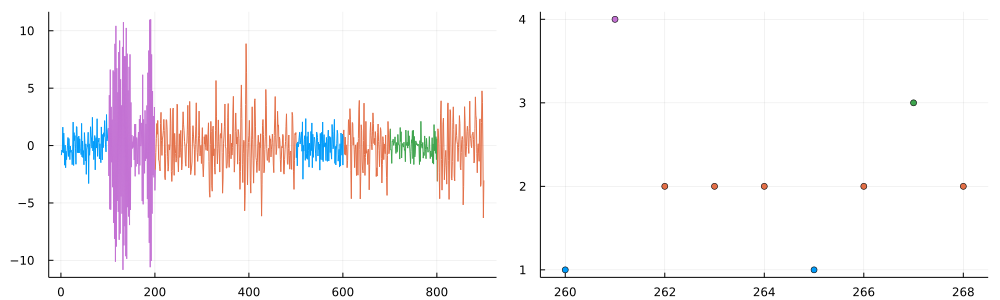

In [11]:
all_data = vcat([first.(ar_data[i][2]) for i in 1:n_datasets]...)
ar_data_len = length(ar_data[1][2])
colors = [i for i in active_scenes for _ in 1:ar_data_len]
gr()
from, to = 260, 268
p1 = plot(all_data[(from-1)*ar_data_len+1:to*ar_data_len], color=colors[(from-1)*ar_data_len+1:to*ar_data_len], label=false)
p2 = scatter(active_scenes, color=active_scenes, xlims=(from-.5,to+.5), label=false)
plot(p1, p2, size=(1000, 300))

In [39]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
Random.seed!(42)

active_models = []
active_scenes = []
vmp_iter = 50
models = convert(AbstractArray{Any}, map(_ -> lar_inference, orders))
priors = map(x -> Dict(:mθ => x[1] .+ sqrt(1e-3)*randn(length(x[1])), :vθ => diageye(length(x[1])), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => x[2], :order => length(x[1])), AR_params)
# Adds gaussian model
push!(models, inference_gaussian)
push!(priors, Dict(:aτ => 1.0, :bτ => 1.0))
# Adds AR(5) model
push!(models, lar_inference)
push!(priors, Dict(:mθ => zeros(5), :vθ => diageye(5), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => 1.0, :order => 5))

ProgressMeter.@showprogress for j in 1:length(ar_data)
    push!(active_scenes, AR_params_seq[j][4])
    observations = first.(ar_data[j][2])
    scene = model_selection(observations, 
                            models,
                            priors,
                            vmp_iter=vmp_iter)
    push!(active_models, scene)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:42:44


In [42]:
JLD.save("verification-jlds/context_inference.jld", "AR_params", AR_params, "active_models", active_models, "active_scenes", active_scenes)

In [8]:
cat_accuracy(active_scenes, active_models)

0.94

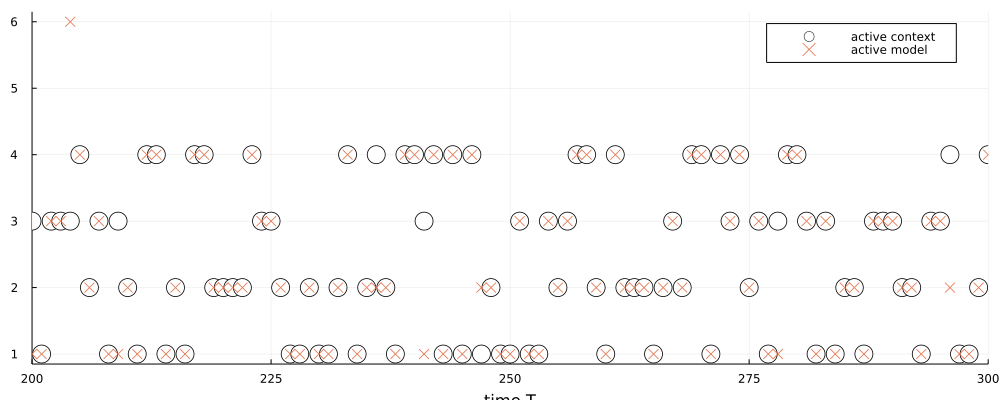

In [9]:
gr()
from, to = 200, 300
scatter(active_scenes, markersize=10.0, label = "active context", xlims=(from, to), markercolor=:white)
scatter!(active_models, markershape=:xcross, markerstrokewidth=5.0, markersize=5.0, label = "active model", xlabel="time T", size=(1000, 400))

In [12]:
using Colors
cols = distinguishable_colors(maximum(Set(colors)), [RGB(0,0,0), RGB(1,1,1)], dropseed=true)
real_colors = map(x -> cols[x], colors);
@show collect(Set(colors))
@show collect(Set(real_colors))

collect(Set(colors)) = [4, 1, 2, 3]
collect(Set(real_colors)) = RGB{FixedPointNumbers.N0f8}[RGB{N0f8}(0.82,0.29,0.0), RGB{N0f8}(0.78,0.129,0.867), RGB{N0f8}(0.0,0.498,0.694), RGB{N0f8}(0.0,0.549,0.0)]


In [11]:
all_data = vcat([first.(ar_data[i][2]) for i in 1:n_datasets]...)
colors = [i for i in active_scenes for _ in 1:ar_data_len]
ar_data_len = length(ar_data[1][2])
window = ar_data_len
pgfplotsx()

from, to = 200, 300
# xtick = from*ar_data_len:1000:to*ar_data_len,
axis1 = @pgf Axis({xlabel=L"t",
           ylabel="value", scaled_x_ticks="base 10:0",
           xtick_distance=1000,
           xmin = (from)*ar_data_len+1, 
           xmax = to*ar_data_len, 
           legend_pos = "outer north east",
           legend_cell_align="{left}",
           grid = "major", style={"ultra thin"},
           width="20cm", height="10cm",
    },
    Plot({no_marks, style={"ultra thick"}, color=cols[1]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-1"),
    Plot({no_marks, style={"ultra thick"}, color=cols[2]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-2"),
    Plot({no_marks, style={"ultra thick"}, color=cols[3]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-3"),
    Plot({no_marks, style={"ultra thick"}, color=cols[4]}, Coordinates(zeros(2), zeros(2))), LegendEntry("AR-4"),
    Iterators.flatten([
                      [Plot(
                            {no_marks, color=real_colors[from*ar_data_len+(i-1)*window+1:from*ar_data_len+i*window][1]},
                            Coordinates(
                                 collect(from*ar_data_len+(i-1)*window+1:from*ar_data_len+i*window), 
                                 all_data[from*ar_data_len+(i-1)*window+1:from*ar_data_len+i*window]
                            ),
                        ) for i in 1:to-from]])...,
)


pgfsave("tmp/context_signals.svg", axis1)
pgfsave("tikz/context_signals.tikz", axis1)

In [7]:
pgfplotsx()
n_datasets = 100

from, to = 200, 300

axis1 = @pgf Axis({xlabel="frame",
           ylabel="models",
           xmin=from-2,
           xmax=to+2,
           xtick_distance=10,
           yticklabels={"_,,AR-1,AR-2, AR-3,AR-4,AR-0, AR-5"},
           legend_pos = "north east",
           legend_cell_align="{left}",
           grid = "major", width="20cm", height="10cm"
    },
    Plot(
        {only_marks,color="black",fill_opacity=0.0, mark_size=3.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(from:to), y = active_scenes[from:to]
        ),
    ), LegendEntry("active context"),
    Plot(
        {fill="black", only_marks,color="red", mark_size=3.0, opacity=1.0, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(from:to), y = active_models[from:to]
        ),
    ), LegendEntry("selected context"),)


pgfsave("tmp/contexts.svg", axis1)
pgfsave("tikz/contexts.tikz", axis1)